# Lung Cancer Classification


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")


In [2]:
train_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\train"
val_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\valid"
test_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\test"

for path_name, path in [("Train", train_path), ("Valid", val_path), ("Test", test_path)]:
    if os.path.exists(path):
        print(f"{path_name} path exists: {path}")
    else:
        print(f"{path_name} path wasn't found: {path}")

Train path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\train
Valid path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\valid
Test path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\test


In [3]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            num_of_image[folder] = len(os.listdir(folder_path))
    return num_of_image

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)

total_train = sum(train_set.values())
total_val = sum(val_set.values())
total_test = sum(test_set.values())


print(f"Train: {total_train} images")
print(f"Valid: {total_val} images")
print(f"test: {total_test} images")
print(f"TOTAL: {total_train + total_val + total_test} images")

Train: 613 images
Valid: 72 images
test: 315 images
TOTAL: 1000 images


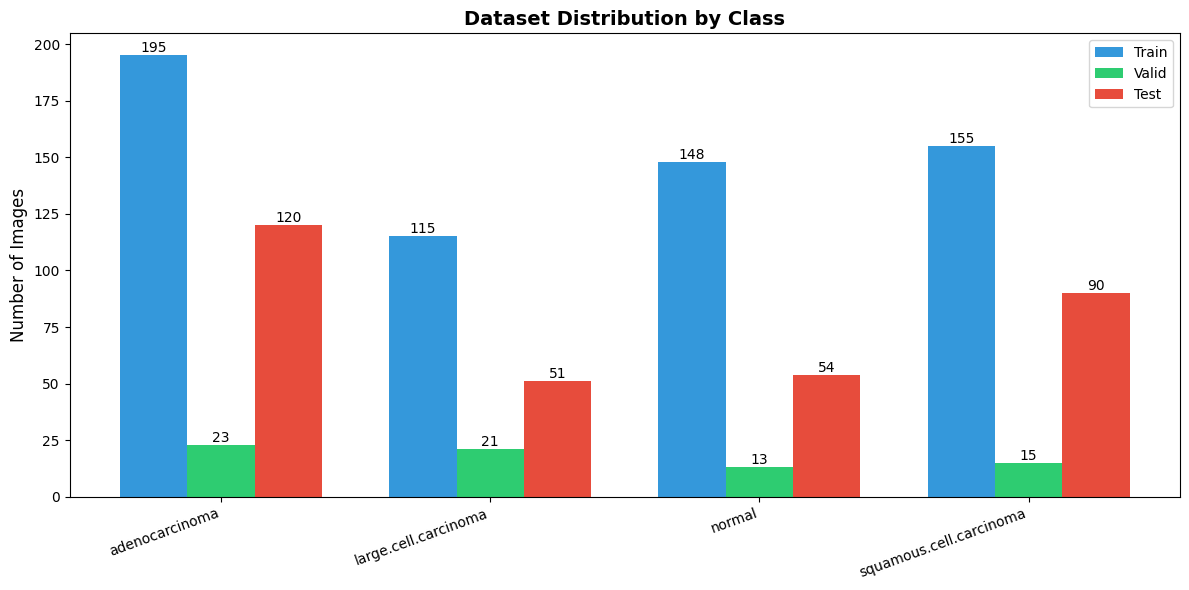

In [4]:
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


train_counts = [195, 115, 148, 155]
val_counts = [23, 21, 13, 15]
test_counts = [120, 51, 54, 90]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train', color='#3498db')
rects2 = ax.bar(x, val_counts, width, label='Valid', color='#2ecc71')
rects3 = ax.bar(x + width, test_counts, width, label='Test', color='#e74c3c')

ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

plt.tight_layout()
plt.show()



In [5]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,           
    horizontal_flip=True,       
    fill_mode='nearest',         
    zoom_range=0.2,              
    shear_range=0.2,            
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    rotation_range=40         
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [6]:
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size=5,               
    target_size=(350, 350),    
    class_mode='categorical'    
)

print("\nTraining Data Info:")
print(f"total images: {train_data.samples}")
print(f"classes: {list(train_data.class_indices.keys())}")
print(f"xclass indices: {train_data.class_indices}")

class_names = list(train_data.class_indices.keys())

Found 613 images belonging to 4 classes.

Training Data Info:
total images: 613
classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
xclass indices: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [7]:
val_data = val_datagen.flow_from_directory(
    val_path,
    batch_size=32,
    target_size=(350, 350),
    class_mode='categorical'
)



Found 72 images belonging to 4 classes.


In [8]:
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size=8,
    target_size=(350, 350),
    class_mode='categorical',
    shuffle=False             
)

print(f"\n Test data loaded: {test_data.samples} images")


Found 315 images belonging to 4 classes.

 Test data loaded: 315 images


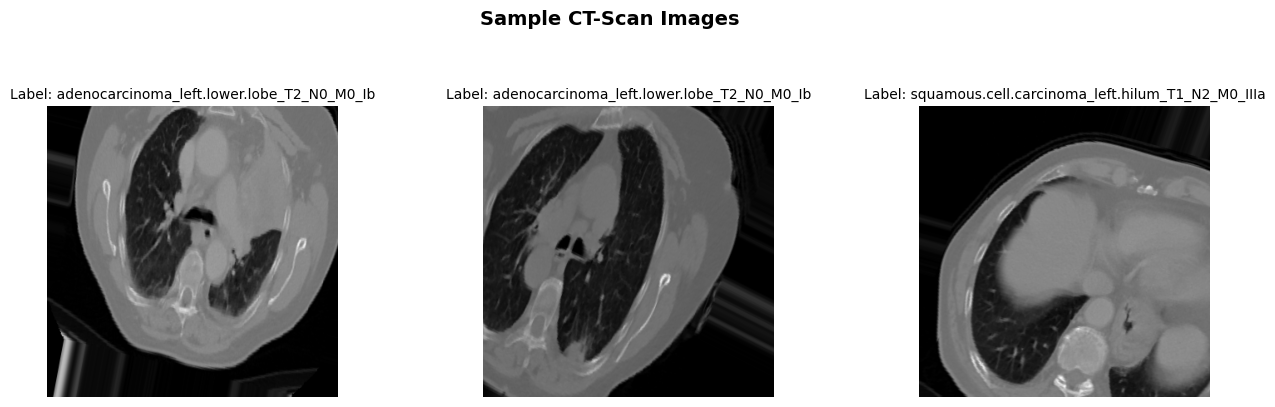

In [9]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)
    
    for i in range(len(images)):
        axs[i].imshow(images[i])
        label_idx = np.argmax(labels[i])
        axs[i].set_title(f"Label: {class_labels[label_idx]}", fontsize=10)
        axs[i].axis('off')
    
    plt.suptitle('Sample CT-Scan Images', fontsize=14, fontweight='bold')
    plt.show()


sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)


In [10]:
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights_array))

for idx, weight in class_weights.items():
    print(f"   {class_names[idx][:35]:35s}: {weight:.4f}")



   adenocarcinoma_left.lower.lobe_T2_N: 0.7859
   large.cell.carcinoma_left.hilum_T2_: 1.3326
   normal                             : 1.0355
   squamous.cell.carcinoma_left.hilum_: 0.9887


In [11]:


base_model = EfficientNetB0(
    input_shape=(350, 350, 3),
    include_top=False,             
    weights='imagenet'             
)

base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)       
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  
model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

In [12]:
learning_rate = 9e-4 

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)


In [13]:

mc = ModelCheckpoint(
    filepath="best_lung_cancer_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=9,                     
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,                 
    patience=2,
    min_delta=0.001,
    mode='max',
    verbose=1
)

callbacks = [mc, early_stopping, reduce_lr]


In [14]:

steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = val_data.samples // val_data.batch_size


history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=32,
    validation_data=val_data,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights,    
    verbose=1
)


Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.4507 - loss: 1.1913
Epoch 1: val_accuracy improved from None to 0.15625, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.4819 - loss: 1.1129 - val_accuracy: 0.1562 - val_loss: 1.6408 - learning_rate: 9.0000e-04
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 977ms/step - accuracy: 0.4000 - loss: 0.9966
Epoch 2: val_accuracy improved from 0.15625 to 0.18750, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4000 - loss: 0.9966 - val_accuracy: 0.1875 - val_loss: 1.5950 - learning_rate: 9.0000e-04
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.6227 - loss: 0.9280
Epoch 3: val_accuracy did not improve from 0.18750
122/122 ━━━━━━━━━━━━━━━━━━━━ 121s 986ms/step - accuracy: 0.6234 - loss: 0.9088 - val_accuracy: 0.0781 - val_loss: 36.0853 - learning_rate: 9.0000e-04
Epoch 4/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:55 958ms/step - accuracy: 0.8000 - loss: 0.6322
Epoch 4: val_accuracy improved from 0.18750 to 0.32812, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8000 - loss: 0.6322 - val_accuracy: 0.3281 - val_loss: 33.2751 - learning_rate: 9.0000e-04
Epoch 5/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5859 - loss: 0.9224
Epoch 5: val_accuracy did not improve from 0.32812
122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 979ms/step - accuracy: 0.6135 - loss: 0.9066 - val_accuracy: 0.2344 - val_loss: 200.8188 - learning_rate: 9.0000e-04
Epoch 6/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:55 951ms/step - accuracy: 1.0000 - loss: 0.2385
Epoch 6: val_accuracy did not improve from 0.32812

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.2385 - val_accuracy: 0.3281 - val_loss: 105.4510 - learning_rate: 9.0000e-04
Epoch 7/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.6955 - loss: 0.6148
Epoch 7: val_accuracy improved from 0.32812 to 0.37500, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 986ms/step - accuracy: 0.7418 - loss: 0.5659 - val_accuracy: 0.3750 - val_loss: 1.4326 - learning_rate: 2.7000e-04
Epoch 8/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:56 967ms/step - accuracy: 0.6000 - loss: 0.7889
Epoch 8: val_accuracy did not improve from 0.37500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6000 - loss: 0.7889 - val_accuracy: 0.3750 - val_loss: 1.4005 - learning_rate: 2.7000e-04
Epoch 9/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.8091 - loss: 0.4802
Epoch 9: val_accuracy did not improve from 0.37500

Epoch 9: ReduceLROnPlateau reducing learning rate to 8.099999686237424e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 979ms/step - accuracy: 0.8289 - loss: 0.4213 - val_accuracy: 0.1406 - val_loss: 626.0328 - learning_rate: 2.7000e-04
Epoch 10/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 982ms/step - accuracy: 0.8000 - loss: 0.3498
Epoch 10: val_accuracy did not improve from 0.37500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 

122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 980ms/step - accuracy: 0.8914 - loss: 0.2880 - val_accuracy: 0.7656 - val_loss: 1.0912 - learning_rate: 7.2900e-06
Epoch 16/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:59 986ms/step - accuracy: 0.6000 - loss: 0.7410
Epoch 16: val_accuracy did not improve from 0.76562
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6000 - loss: 0.7410 - val_accuracy: 0.7188 - val_loss: 1.3392 - learning_rate: 7.2900e-06
Epoch 17/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.8738 - loss: 0.3136
Epoch 17: val_accuracy did not improve from 0.76562

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.186999927289435e-06.
122/122 ━━━━━━━━━━━━━━━━━━━━ 119s 975ms/step - accuracy: 0.8586 - loss: 0.3429 - val_accuracy: 0.7188 - val_loss: 0.8280 - learning_rate: 7.2900e-06
Epoch 18/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:54 950ms/step - accuracy: 1.0000 - loss: 0.1920
Epoch 18: val_accuracy did not improve from 0.76562
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accurac

122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 983ms/step - accuracy: 0.8717 - loss: 0.3149 - val_accuracy: 0.7969 - val_loss: 0.7544 - learning_rate: 2.1870e-06
Epoch 20/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:57 969ms/step - accuracy: 1.0000 - loss: 0.1575
Epoch 20: val_accuracy did not improve from 0.79688
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.1575 - val_accuracy: 0.7969 - val_loss: 0.7894 - learning_rate: 2.1870e-06
Epoch 21/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.8669 - loss: 0.3034
Epoch 21: val_accuracy improved from 0.79688 to 0.85938, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 122s 997ms/step - accuracy: 0.8618 - loss: 0.3157 - val_accuracy: 0.8594 - val_loss: 0.7218 - learning_rate: 2.1870e-06
Epoch 22/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 1.0000 - loss: 0.1327
Epoch 22: val_accuracy did not improve from 0.85938
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 1.0000 - loss: 0.1327 - val_accuracy: 0.8594 - val_loss: 0.7220 - learning_rate: 2.1870e-06
Epoch 23/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8910 - loss: 0.3060
Epoch 23: val_accuracy improved from 0.85938 to 0.87500, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 983ms/step - accuracy: 0.8882 - loss: 0.3032 - val_accuracy: 0.8750 - val_loss: 0.6662 - learning_rate: 2.1870e-06
Epoch 24/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.6000 - loss: 0.5974
Epoch 24: val_accuracy did not improve from 0.87500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6000 - loss: 0.5974 - val_accuracy: 0.8750 - val_loss: 0.6518 - learning_rate: 2.1870e-06
Epoch 25/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.8821 - loss: 0.2697
Epoch 25: val_accuracy did not improve from 0.87500

Epoch 25: ReduceLROnPlateau reducing learning rate to 6.560999509019894e-07.
122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 983ms/step - accuracy: 0.8569 - loss: 0.3314 - val_accuracy: 0.6562 - val_loss: 1.1991 - learning_rate: 2.1870e-06
Epoch 26/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 979ms/step - accuracy: 1.0000 - loss: 0.1312
Epoch 26: val_accuracy did not improve from 0.87500
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 

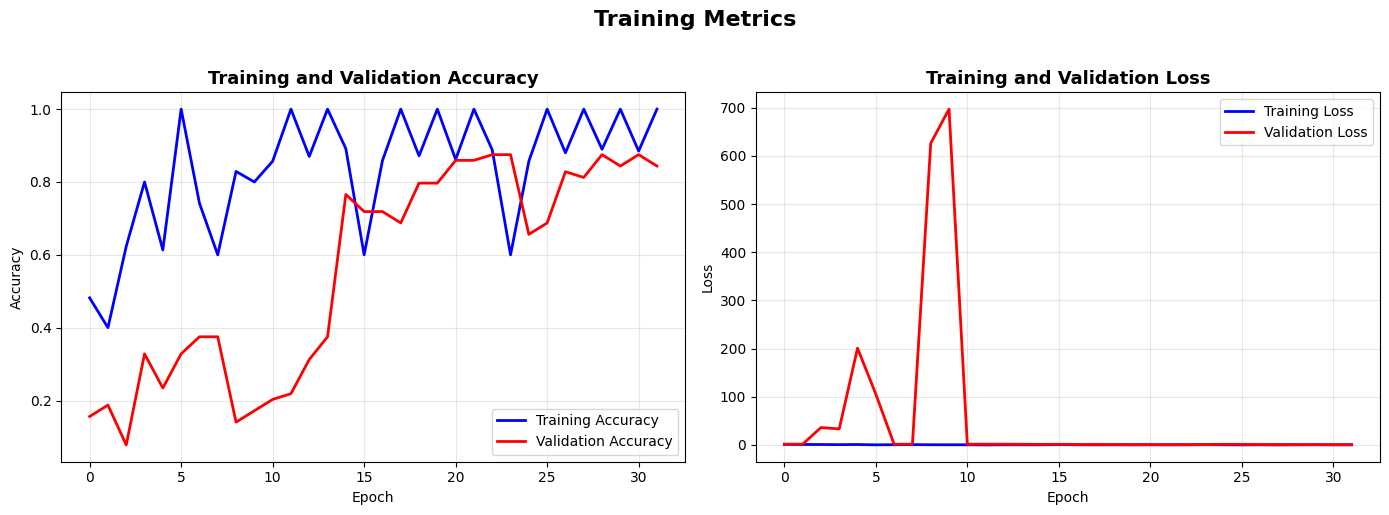

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


ax1.plot(epochs_range, accuracy, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs_range, val_accuracy, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Training Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



In [16]:

best_model = load_model("best_lung_cancer_model.h5")

test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)

print(f"\n TEST RESULTS:")
print(f" Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss: {test_loss:.4f}")




 TEST RESULTS:
 Accuracy: 84.76%
  Loss: 0.4297


In [17]:

test_data.reset()
y_pred_prob = best_model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_data.classes

test_class_names = list(test_data.class_indices.keys())


print(classification_report(
    y_true,
    y_pred,
    target_names=test_class_names,
    digits=4
))



40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step
                         precision    recall  f1-score   support

         adenocarcinoma     0.9457    0.7250    0.8208       120
   large.cell.carcinoma     0.6220    1.0000    0.7669        51
                 normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma     0.8636    0.8444    0.8539        90

               accuracy                         0.8476       315
              macro avg     0.8578    0.8877    0.8581       315
           weighted avg     0.8791    0.8476    0.8506       315



In [18]:

unique_predictions = np.unique(y_pred)

print(f"\nCLASSES BEING PREDICTED:")
for i in range(4):
    if i in unique_predictions:
        count = sum(y_pred == i)
        print(f"{test_class_names[i]:30s}: {count} predictions")
    else:
        print(f"{test_class_names[i]:30s}: 0 predictions (NOT LEARNED!)")




CLASSES BEING PREDICTED:
adenocarcinoma                : 92 predictions
large.cell.carcinoma          : 82 predictions
normal                        : 53 predictions
squamous.cell.carcinoma       : 88 predictions


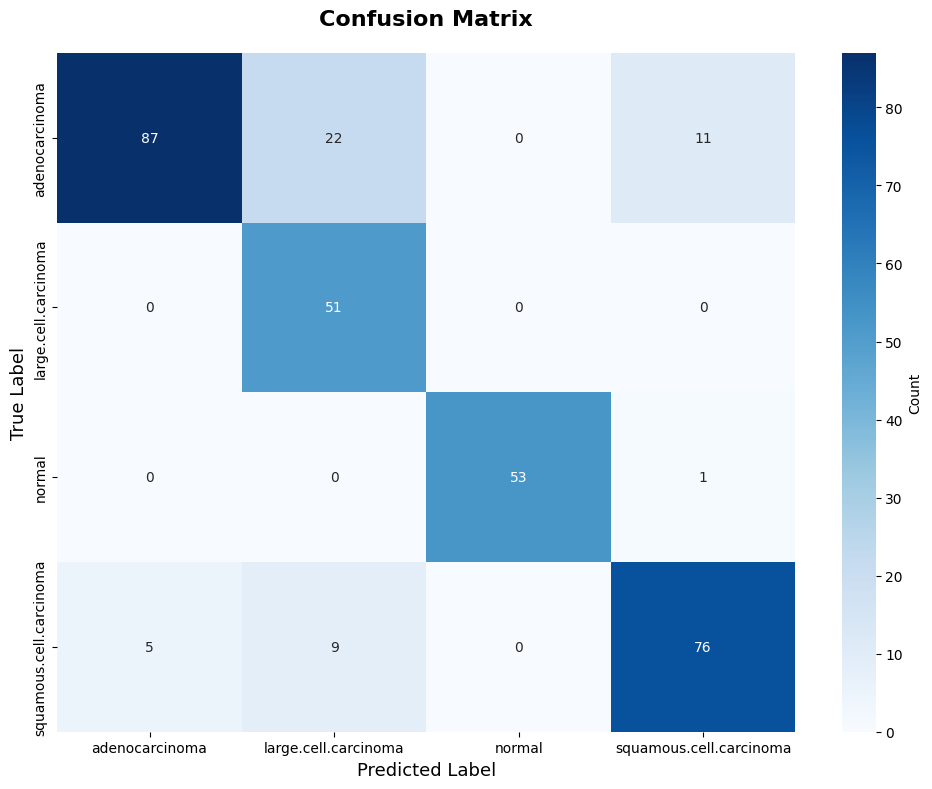

In [19]:

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_class_names,
    yticklabels=test_class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [20]:


for i, class_name in enumerate(test_class_names):
    if i < len(cm):
        correct = cm[i, i]
        total = cm[i, :].sum()
        accuracy = (correct / total * 100) if total > 0 else 0
        

        
        print(f"{class_name:30s}: {correct:3d}/{total:3d} ({accuracy:5.1f}%)")



adenocarcinoma                :  87/120 ( 72.5%)
large.cell.carcinoma          :  51/ 51 (100.0%)
normal                        :  53/ 54 ( 98.1%)
squamous.cell.carcinoma       :  76/ 90 ( 84.4%)


In [21]:


final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nRESULTS:")
print(f"   Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"   Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"   Test Accuracy:       {test_accuracy*100:.2f}%")




RESULTS:
   Training Accuracy:   100.00%
   Validation Accuracy: 84.38%
   Test Accuracy:       84.76%
